# Self-Driving Car Engineer Nanodegree


## Project 3: Behavioral Cloning
August 2017


---

## Goal
The goal of this project is to build a machine learning model that can successfully steer a car around a race track that it's never encountered before.

The details for this project are located here at [Udacity's Github repo](https://github.com/udacity/CarND-Behavioral-Cloning-P3). My implementation of the project can be found [here at my Github repo](https://github.com/tommytracey/udacity/tree/master/self-driving-nano/projects/3-behavioral-cloning).


---
## Initial Setup

#### Import Modules

In [1]:
import csv
import cv2
import keras
import keras.backend
from keras.callbacks import ModelCheckpoint, Callback
from keras.layers.core import Activation, Dense, Dropout, Flatten, Lambda, Reshape
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.models import Sequential, model_from_json
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.regularizers import l2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tqdm import tqdm


Using TensorFlow backend.


#### Verify that Keras is using Tensforflow backend

The Keras backend uses Theano by default and changing it to Tensorflow can be tricky via Jupyter. Simply updating the config json file `$HOME/.keras/keras.json` as directed in [Keras backend documentation](https://keras.io/backend/) did not work for me. Trying to set it _before or after loading the notebook_ did not work eithter when using:

`$ os.environ["KERAS_BACKEND"]="tensorflow"`

The only way I could reliably set Tensorflow as the backend was to use the following command **UPON loading the notebook**:

`$ KERAS_BACKEND=tensorflow jupyter notebook`

(NOTE: You can also append `--NotebookApp.iopub_data_rate_limit=10000000000` to the above command if your notebook includes a lot of visualizations. This will help prevent the kernel from crashing and/or causing you to lose your connection to your AWS EC2 instance.)

Re: the backend, **the cell below only provides a sanity check that the backend is configured as expected**. Note that the version of Tensorflow being used by Keras may be different than the one you typically run in your environment. 

[This post](https://www.nodalpoint.com/switch-keras-backend/) by Christos-Iraklis Tsatsoulis provides even more detail if you'd like to further understand the issues and automate the setup process.

In [2]:
print('Keras version: ', keras.__version__)
print('Tensorflow version: ', tf.__version__)
print('Keras backend: ', keras.backend.backend())
print('keras.backend.image_dim_ordering = ', keras.backend.image_dim_ordering())

os.environ["KERAS_BACKEND"] = "tensorflow"
if keras.backend.backend() != 'tensorflow':
    raise BaseException("This script uses other backend")
else:
    keras.backend.set_image_dim_ordering('tf')
    print("\nBackend OK")

Keras version:  2.0.6
Tensorflow version:  1.2.1
Keras backend:  tensorflow
keras.backend.image_dim_ordering =  tf

Backend OK


---
# Step 1: Load and preview the data

---

### Data Source A: Provided by Udacity

In [3]:
# Load UDACITY data into a list
with open('data/udacity/driving_log.csv', newline='') as f:
    udacity_data = list(csv.reader(f, skipinitialspace=True, delimiter=',', quoting=csv.QUOTE_NONE))
    
# Load UDACITY data from .csv and preview it in Pandas dataframe
udacity_df = pd.read_csv('data/udacity/driving_log.csv', header=0)

print('total rows: ', len(udacity_df))
udacity_df.head()

total rows:  8036


,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


### Data Source B: Self-generated using simulator

#### Preview the data

In [68]:
# Load SELF data into list
with open('data/self/driving_log.csv', newline='') as f:
    self_data = list(csv.reader(f, skipinitialspace=True, delimiter=',', quoting=csv.QUOTE_NONE))

# Load SELF data from .csv and preview it in Pandas dataframe
self_df = pd.read_csv('data/self/driving_log.csv', header=0)

print('total rows: ', len(self_df))
self_df.head()

total rows:  13594


,center,left,right,steering,throttle,brake,speed
0,/Users/thomastracey/Desktop/self/hard-turns-1/...,/Users/thomastracey/Desktop/self/hard-turns-1/...,/Users/thomastracey/Desktop/self/hard-turns-1/...,0.00,1.0,0.0,30.19030
1,/Users/thomastracey/Desktop/self/hard-turns-1/...,/Users/thomastracey/Desktop/self/hard-turns-1/...,/Users/thomastracey/Desktop/self/hard-turns-1/...,0.00,1.0,0.0,30.19024
2,/Users/thomastracey/Desktop/self/hard-turns-1/...,/Users/thomastracey/Desktop/self/hard-turns-1/...,/Users/thomastracey/Desktop/self/hard-turns-1/...,0.00,1.0,0.0,30.19029
3,/Users/thomastracey/Desktop/self/hard-turns-1/...,/Users/thomastracey/Desktop/self/hard-turns-1/...,/Users/thomastracey/Desktop/self/hard-turns-1/...,0.00,1.0,0.0,30.19031
4,/Users/thomastracey/Desktop/self/hard-turns-1/...,/Users/thomastracey/Desktop/self/hard-turns-1/...,/Users/thomastracey/Desktop/self/hard-turns-1/...,-0.05,1.0,0.0,30.18972


#### Data Set: Initial Observations
We can see from the table above that the driving data includes:
- relative paths to .jpg images from three different camera angles (center, left, right)
- floating point measurements of the vehicle's steering angle, throttle, brake, and speed
- the data appears to be time series, although no time stamps are included

## Preview the driving images

The driving images are the training features for our model. We need to look at samples of these images and start thinking about how various characteristics might affect the model (positively or negatively). 

In [5]:
## Preview a random set of images from each camera angle

index = random.randint(0, len(udacity_df))
img_dir = 'data/udacity/'

center_img_orig = mpimg.imread(img_dir + udacity_data[index][0])
left_img_orig = mpimg.imread(img_dir + udacity_data[index][1])
right_img_orig = mpimg.imread(img_dir + udacity_data[index][2])

center_steer = udacity_data[index][3]

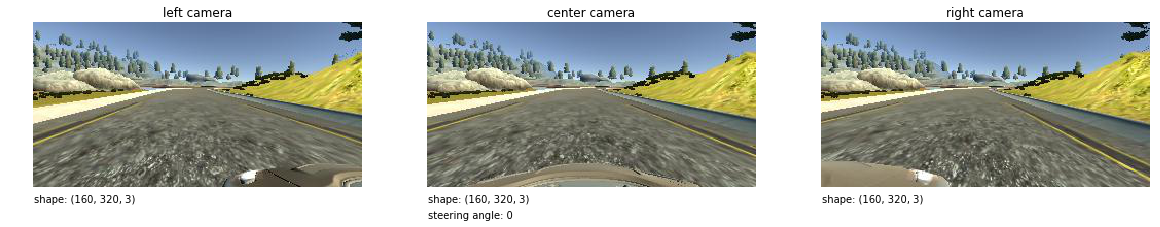

In [6]:
# Display visualizations in the notebook
%matplotlib inline

plt.figure(figsize=(20,5))

plt.subplot2grid((1, 3), (0, 0));
plt.axis('off')
plt.title('left camera')
plt.text(0, left_img_orig.shape[0]+15, ('shape: ' + str(left_img_orig.shape)))
plt.imshow(left_img_orig, cmap="gray")

plt.subplot2grid((1, 3), (0, 1));
plt.axis('off')
plt.title('center camera')
plt.text(0, center_img_orig.shape[0]+15, ('shape: ' + str(center_img_orig.shape)))
plt.text(0, center_img_orig.shape[0]+30, ('steering angle: ' + center_steer))
plt.imshow(center_img_orig, cmap="gray")

plt.subplot2grid((1, 3), (0, 2));
plt.axis('off')
plt.title('right camera')
plt.text(0, right_img_orig.shape[0]+15, ('shape: ' + str(right_img_orig.shape)))
plt.imshow(right_img_orig, cmap="gray")

#### Driving Images: Initial Observations
We can see from the images above that:
- the images are taken in the front of the car (no side or rear angles)
- each image is 160x320 with 3 RGB color channels
- there is quite a bit of superfluous data, i.e. data that won't benefit the model; for example the sky, hills, trees in the background, as well as the hood of the car).

If you view enough images or actually run the simulator, you also see that:
- there are a lot of turns in the road (duh!), but since the track ultimately ends where it started, there seems to be more turns in one direction than the other
- the lane markings change shape and color at different points in the track, and at some points there are no markings at all!
- all of the images are consistently bright; no glare, no darkness, and no shadows that you'd usually encounter with normal driving

Given the simulation takes place on a race track (not a highway), the road is free of additional cars, traffic signs, lanes, etc. We won't account for these in this project, but a more robust driving model would need training data that included these conditions. 

That said, many of the other items above can create biases in our model and cause it to overfit the specific driving conditions within this particular simulation. We need to correct for these so that our model learns to drive in a variety of conditions we might find on other tracks. We'll do this by pre-processing and augmenting our training data throughout the sections to follow. But first let's look at our target data (steering angles) to see if there's anything else we need to correct for. 

## Examine the steering angles
The steering angles are our target data for training the model. That is, based on the images fed into the model while the car is driving along the track, the model will predict the appropriate steering angle to navigate the patch of road ahead.

#### Distribution

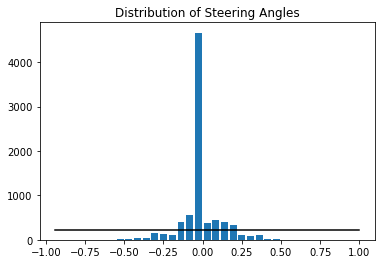

In [7]:
%matplotlib inline

angles = udacity_df.steering.tolist()
num_bins = 35
avg_per_bin = len(angles) / num_bins

hist, bins = np.histogram(angles, num_bins)
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.title('Distribution of Steering Angles')
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(angles), np.max(angles)), (avg_per_bin, avg_per_bin), 'k-')
plt.show()

**Steering Angle Observations**:

We can see from the graph above that an overwhelming amount of the target data are steering angles close to zero (i.e., when the car is driving straight). This biases our model to drive the car straight and make it's difficult to learn how to navigate turns. 

It also seems there may be an imbalance in left vs. right turning data (although not as much as I had expected). It's not clear how big of an impact this would have on the model, but there's a chance the model could learn to turn more effectively in one direction than the other. Just to be safe we'll correct for this by ensuring there are equal quantities of left and right steering data after pre-processing. 

---
# Step 2: Data pre-processing
---

### 2.1 | Overview of Data Sources and Splits

**Data Sources**: 
- There are two tracks, but all of the original training and validation data is generated by driving the simulator on **Track 1**.
- Udacity provides an intial set of "good" data to get us started.
- Additional data is gathered by running the simulator myself. 

**Training Data**:
- The training data set includes the original image data captured from the simulator on Track 1, plus any additional data generated via pre-processing and augmentation. 

**Validation Data**:
- The validation data will contain the original image data captured from the simulator on Track 1, with only a pre-process to create a more balanced distribution (i.e., reduce the 'drive straight' bias). No other pre-processing or augmentation is included. This ensures we can properly validate whether changes we're making to the model or training data are increasing or decreasing the model's performance. 

**Test Data**:
- We'll test the model's ability to generalize by running it on **Track 2**. So, the simulator input images from Track 2 will serve as our test data.

In [83]:
## Set data sources

sources = ['udacity', 'self', 'combined']
default_source = sources[0]

## Function to reference image directory for a given source
def img_dir(source):
    return "data/" + source + "/IMG/"


### 2.2 | Data Hygiene

Before going any further there are few aspects of the data we need to cleanup to make the data easier to work with.

1. We're only using the steering data to train the model, so we can prune out the other measurements (throttle, brake, and speed).
2. Remove the directory from image path data. We'll be moving our data around and we only want the image filename. 
3. Cast all of the steering data as floats. In the .csv they're cast as strings. 

#### Udacity data hygiene

In [9]:
# column references for source data: 
# 0=center_img, 1=left_img, 2=right_img, 3=steering, 4=throttle, 5=brake, 6=speed

udacity_clean = []

for row in udacity_data[1:]:
    # Remove directory from image paths
    center = row[0].split('/')[-1]
    left = row[1].split('/')[-1]
    right = row[2].split('/')[-1]
    
    # Only grab the steering data and cast as float
    angle = float(row[3])
    
    udacity_clean.append([center, left, right, angle])

print('number of records: ', len(udacity_clean))
print('\nfirst 3 records:\n', udacity_clean[0:3])

number of records:  8036

first 3 records:
 [['center_2016_12_01_13_30_48_287.jpg', 'left_2016_12_01_13_30_48_287.jpg', 'right_2016_12_01_13_30_48_287.jpg', 0.0], ['center_2016_12_01_13_30_48_404.jpg', 'left_2016_12_01_13_30_48_404.jpg', 'right_2016_12_01_13_30_48_404.jpg', 0.0], ['center_2016_12_01_13_31_12_937.jpg', 'left_2016_12_01_13_31_12_937.jpg', 'right_2016_12_01_13_31_12_937.jpg', 0.0]]


#### Self-generated data hygiene

In [69]:
# Load SELF data into a list
with open('data/self/driving_log.csv', newline='') as f:
    self_data = list(csv.reader(f, skipinitialspace=True, delimiter=',', quoting=csv.QUOTE_NONE))
    
# column references: 0=center_img, 1=left_img, 2=right_img, 3=steering, 4=throttle, 5=brake, 6=speed

self_clean = []

for row in self_data[1:]:
    # Remove directory from image paths
    center = row[0].split('/')[-1]
    left = row[1].split('/')[-1]
    right = row[2].split('/')[-1]
    
    # Only grab the steering data and cast as float
    angle = float(row[3])
    
    self_clean.append([center, left, right, angle])

print('number of records: ', len(self_clean))
print('\nfirst 3 records:\n', self_clean[0:3])

number of records:  13594

first 3 records:
 [['center_2017_08_11_14_41_56_922.jpg', 'left_2017_08_11_14_41_56_922.jpg', 'right_2017_08_11_14_41_56_922.jpg', 0.0], ['center_2017_08_11_14_41_57_006.jpg', 'left_2017_08_11_14_41_57_006.jpg', 'right_2017_08_11_14_41_57_006.jpg', 0.0], ['center_2017_08_11_14_41_57_092.jpg', 'left_2017_08_11_14_41_57_092.jpg', 'right_2017_08_11_14_41_57_092.jpg', 0.0]]


### 2.3 | Seperate C/L/R camera data and adjust steering angles for left and right turns
Right now, each row of the data set contains three camera angles (center, left, right) and one steering angle which pertains to the center camera. In order to utilize all of the different camera data, we need to: 

1. Separate the data for each of the different camera angles (only one camera angle per row)
2. Adjust the steering angles for the left and right cameras _while the car is turning_. This will compensate for their respective vantage points relative to the center of the car. That is, the steering angle for a right turn should be sharper from the persective of the left camera (and vice versa). 

In [11]:
turn_thresh = 0.1   # the angle threshold used to identify left and right turns

def steer_correct(angle):
    '''Calculates the steering angle factor applied to left and right cameras while turning.
    
    Ensures that sharper turns receive a low multiplication factor than softer turns. 
    '''
    corr_factor = (-1.15 * abs(angle)) + 2.15
    new_angle = corr_factor * angle
    return new_angle  

#### Udacity data

In [12]:
udacity_3cam = []
source = sources[0]  # udacity

for row in udacity_clean:
    # left camera with adjusted steering angle
    if row[3] > turn_thresh:    # if right turn
        img_left = row[1]
        ang_left = steer_correct(row[3])
        udacity_3cam.append([img_left, ang_left, source])
            
    # right camera with adjusted steering angle
    if row[3] < -turn_thresh:    # if left turn
        img_right = row[2]
        ang_right = steer_correct(row[3])
        udacity_3cam.append([img_right, ang_right, source])
        
    # center camera and steering angle are kept as is
    img_center, ang_center = row[0], row[3]
    udacity_3cam.append([img_center, ang_center, source])

In [13]:
udacity_3cam[0]

['center_2016_12_01_13_30_48_287.jpg', 0.0, 'udacity']

#### Self-generated data

In [70]:
self_3cam = []
source = sources[1]  # self

for row in self_clean:
    # left camera with adjusted steering angle
    if row[3] > turn_thresh:    # if right turn
        img_left = row[1]
        ang_left = steer_correct(row[3])
        self_3cam.append([img_left, ang_left, source])
    
    # right camera with adjusted steering angle
    if row[3] < -turn_thresh:    # if left turn
        img_right = row[2]
        ang_right = steer_correct(row[3])
        self_3cam.append([img_right, ang_right, source])
    
    # center camera and steering angle are kept as is
    img_center, ang_center = row[0], row[3]
    self_3cam.append([img_center, ang_center, source])


### 2.4 | Crop & Flip

In [15]:
## Define cropping dimensions

# Crop settings provided to Keras Cropping2D layer
crop_set = (60, 20), (20, 20)   # number of pixels to remove from (top, bottom), (left, right)
    
# Define image shapes 
orig_shape = center_img_orig.shape  # (160, 320, 3)
crop_shape = (
    orig_shape[0]-(crop_set[0][0]+crop_set[0][1]), \
    orig_shape[1]-(crop_set[1][0]+crop_set[1][1]),  \
    orig_shape[2]
)

# Define resulting crop points for preview cell below
h1, h2 = (crop_set[0][0], orig_shape[0]-crop_set[0][1])
w1, w2 = (crop_set[1][0], orig_shape[1]-crop_set[1][1])


print('orig_shape: ', orig_shape)
print('crop_shape: ', crop_shape)
print('crop points [h1:h2,w1:w2] = [{}:{},{}:{}]'.format(h1, h2, w1, w2))

orig_shape:  (160, 320, 3)
crop_shape:  (80, 280, 3)
crop points [h1:h2,w1:w2] = [60:140,20:300]


#### Preview Udacity Images (Cropped & Flipped)

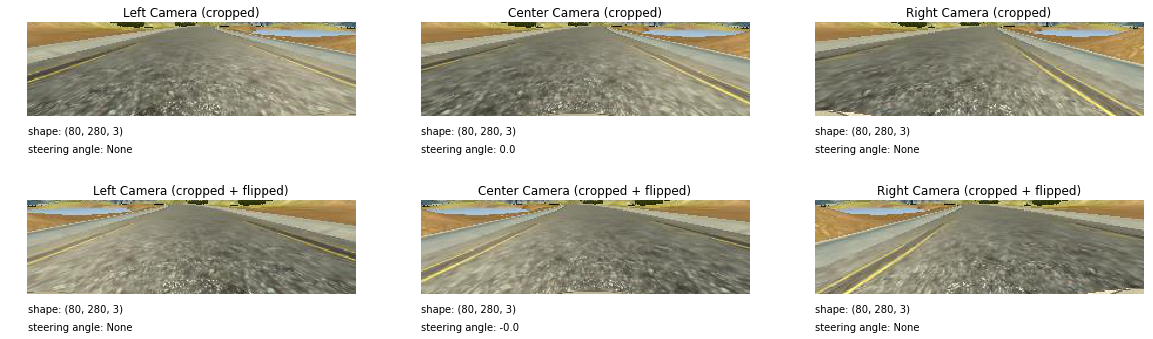

In [16]:
## Preview cropped and flipped images

index = random.randint(0, len(udacity_data))
img_dir = 'data/udacity/'

# Select a random set of images to crop
center_img_crop = mpimg.imread(img_dir + udacity_data[index][0])[h1:h2,w1:w2]
left_img_crop = mpimg.imread(img_dir + udacity_data[index][1])[h1:h2,w1:w2]
right_img_crop = mpimg.imread(img_dir + udacity_data[index][2])[h1:h2,w1:w2]

# Create flipped versions
center_img_flip = cv2.flip(center_img_crop, 1)
left_img_flip = cv2.flip(left_img_crop, 1)
right_img_flip = cv2.flip(right_img_crop, 1)

# Calculate steering angles
center_steer = float(udacity_data[index][3])
left_steer = None
left_steer_flip = None 
right_steer = None
right_steer_flip = None
if center_steer > turn_thresh:
    left_steer = steer_correct(center_steer)
    left_steer_flip = -steer_correct(center_steer)
if center_steer < -turn_thresh:
    right_steer = steer_correct(center_steer)
    right_steer_flip = -steer_correct(center_steer)
    
# Display visualizations in the notebook
%matplotlib inline

plt.figure(figsize=(20,6))

# Cropped versions
plt.subplot2grid((2, 3), (0, 0));
plt.axis('off')
plt.title('Left Camera (cropped)')
plt.text(0, left_img_crop.shape[0]+15, ('shape: ' + str(left_img_crop.shape)))
plt.text(0, left_img_crop.shape[0]+30, ('steering angle: ' + str(left_steer)))
plt.imshow(left_img_crop, cmap="gray")

plt.subplot2grid((2, 3), (0, 1));
plt.axis('off')
plt.title('Center Camera (cropped)')
plt.text(0, center_img_crop.shape[0]+15, ('shape: ' + str(center_img_crop.shape)))
plt.text(0, center_img_crop.shape[0]+30, ('steering angle: ' + str(center_steer)))
plt.imshow(center_img_crop, cmap="gray")

plt.subplot2grid((2, 3), (0, 2));
plt.axis('off')
plt.title('Right Camera (cropped)')
plt.text(0, right_img_crop.shape[0]+15, ('shape: ' + str(right_img_crop.shape)))
plt.text(0, right_img_crop.shape[0]+30, ('steering angle: ' + str(right_steer)))
plt.imshow(right_img_crop, cmap="gray")

# Flipped version
plt.subplot2grid((2, 3), (1, 0));
plt.axis('off')
plt.title('Left Camera (cropped + flipped)')
plt.text(0, left_img_flip.shape[0]+15, ('shape: ' + str(left_img_flip.shape)))
plt.text(0, left_img_flip.shape[0]+30, ('steering angle: ' + str(left_steer_flip)))
plt.imshow(left_img_flip, cmap="gray")

plt.subplot2grid((2, 3), (1, 1));
plt.axis('off')
plt.title('Center Camera (cropped + flipped)')
plt.text(0, center_img_flip.shape[0]+15, ('shape: ' + str(center_img_flip.shape)))
plt.text(0, center_img_flip.shape[0]+30, ('steering angle: ' + str(-center_steer)))
plt.imshow(center_img_flip, cmap="gray")

plt.subplot2grid((2, 3), (1, 2));
plt.axis('off')
plt.title('Right Camera (cropped + flipped)')
plt.text(0, right_img_flip.shape[0]+15, ('shape: ' + str(right_img_flip.shape)))
plt.text(0, right_img_flip.shape[0]+30, ('steering angle: ' + str(right_steer_flip)))
plt.imshow(right_img_flip, cmap="gray")

#### Preview Self-generated Images (Cropped & Flipped)

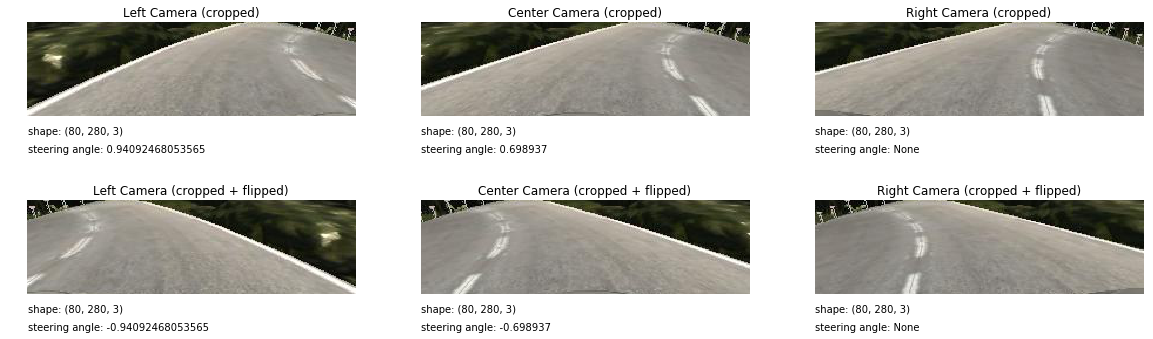

In [75]:
## Preview cropped and flipped images

index = random.randint(0, len(self_data))
img_dir = 'data/self/IMG/'

# Select a random set of images to crop
center_img_crop_self = mpimg.imread(img_dir + self_data[index][0].split('/')[-1])[h1:h2,w1:w2]
left_img_crop_self = mpimg.imread(img_dir + self_data[index][1].split('/')[-1])[h1:h2,w1:w2]
right_img_crop_self = mpimg.imread(img_dir + self_data[index][2].split('/')[-1])[h1:h2,w1:w2]

# Create flipped versions
center_img_flip_self = cv2.flip(center_img_crop_self, 1)
left_img_flip_self = cv2.flip(left_img_crop_self, 1)
right_img_flip_self = cv2.flip(right_img_crop_self, 1)

# Calculate steering angles
center_steer = float(self_data[index][3])
left_steer = None
left_steer_flip_self = None 
right_steer = None
right_steer_flip_self = None
if center_steer > turn_thresh:
    left_steer = steer_correct(center_steer)
    left_steer_flip_self = -steer_correct(center_steer)
if center_steer < -turn_thresh:
    right_steer = steer_correct(center_steer)
    right_steer_flip_self = -steer_correct(center_steer)
    
# Display visualizations in the notebook
%matplotlib inline

plt.figure(figsize=(20,6))

# Cropped versions
plt.subplot2grid((2, 3), (0, 0));
plt.axis('off')
plt.title('Left Camera (cropped)')
plt.text(0, left_img_crop_self.shape[0]+15, ('shape: ' + str(left_img_crop_self.shape)))
plt.text(0, left_img_crop_self.shape[0]+30, ('steering angle: ' + str(left_steer)))
plt.imshow(left_img_crop_self, cmap="gray")

plt.subplot2grid((2, 3), (0, 1));
plt.axis('off')
plt.title('Center Camera (cropped)')
plt.text(0, center_img_crop_self.shape[0]+15, ('shape: ' + str(center_img_crop_self.shape)))
plt.text(0, center_img_crop_self.shape[0]+30, ('steering angle: ' + str(center_steer)))
plt.imshow(center_img_crop_self, cmap="gray")

plt.subplot2grid((2, 3), (0, 2));
plt.axis('off')
plt.title('Right Camera (cropped)')
plt.text(0, right_img_crop_self.shape[0]+15, ('shape: ' + str(right_img_crop_self.shape)))
plt.text(0, right_img_crop_self.shape[0]+30, ('steering angle: ' + str(right_steer)))
plt.imshow(right_img_crop_self, cmap="gray")

# Flipped version
plt.subplot2grid((2, 3), (1, 0));
plt.axis('off')
plt.title('Left Camera (cropped + flipped)')
plt.text(0, left_img_flip_self.shape[0]+15, ('shape: ' + str(left_img_flip_self.shape)))
plt.text(0, left_img_flip_self.shape[0]+30, ('steering angle: ' + str(left_steer_flip_self)))
plt.imshow(left_img_flip_self, cmap="gray")

plt.subplot2grid((2, 3), (1, 1));
plt.axis('off')
plt.title('Center Camera (cropped + flipped)')
plt.text(0, center_img_flip_self.shape[0]+15, ('shape: ' + str(center_img_flip_self.shape)))
plt.text(0, center_img_flip_self.shape[0]+30, ('steering angle: ' + str(-center_steer)))
plt.imshow(center_img_flip_self, cmap="gray")

plt.subplot2grid((2, 3), (1, 2));
plt.axis('off')
plt.title('Right Camera (cropped + flipped)')
plt.text(0, right_img_flip_self.shape[0]+15, ('shape: ' + str(right_img_flip_self.shape)))
plt.text(0, right_img_flip_self.shape[0]+30, ('steering angle: ' + str(right_steer_flip_self)))
plt.imshow(right_img_flip_self, cmap="gray")

### 2.5 | Other Transformations

Generates batches of tensor image data that is augmented based on a chosen set of tranformation parameters (e.g. rotation, shift, shear, zoom).

In [17]:
# datagen_3 = ImageDataGenerator(featurewise_center=False,
#     samplewise_center=False,
#     featurewise_std_normalization=False,
#     samplewise_std_normalization=False,
#     zca_whitening=True,
#     zca_epsilon=1e-6,
#     rotation_range=2.,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.01,
#     zoom_range=0.,
#     channel_shift_range=0.1,
#     fill_mode='nearest',
#     cval=0.,
#     horizontal_flip=False,
#     vertical_flip=False,
#     rescale=None,
#     preprocessing_function=None)

In [48]:
def brightness(image):
    #Convert 2 HSV colorspace from RGB colorspace
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    #Generate new random brightness
    rand = random.uniform(0.3,1.0)
    hsv[:,:,2] = rand*hsv[:,:,2]
    
    #Convert back to RGB colorspace
    new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    return new_img 

In [65]:
# Image transformation function

image = np.empty((160, 320, 3), dtype='uint8')

keras_datagen = ImageDataGenerator(
#     zca_whitening=True,
    rotation_range=2,
    width_shift_range=0.05,
    height_shift_range=0.05,
#     shear_range=0.5,
#     zoom_range=0.15,
    channel_shift_range=10.0,
    fill_mode='nearest',
    preprocessing_function=brightness
)


In [54]:
## Create AUGMENTED training sets **WORKING VERSION**

X_batch = [(i[0], i[2]) for i in udacity_3cam[0:64]]
y_batch = [i[1] for i in udacity_3cam[0:64]]

X_images = np.empty((0, 160, 320, 3), dtype='uint8')
y_angles = np.empty(0, dtype='float32')

source = default_source

for i in range(len(y_batch)):
    # retrieve the image from local directory
    source = str(X_batch[i][1])
    filename = str(X_batch[i][0])
    img_path = img_dir(source) + filename
    img = [mpimg.imread(img_path.strip())]
    angle = [y_batch[i]]
    X_images = np.append(X_images, img, axis=0)
    y_angles = np.append(y_angles, angle, axis=0) 
    
X_aug = np.empty((0, 160, 320, 3))
y_aug = np.empty(0, dtype='float32')

print('Augmenting Image Data...')

# seed = random.randint(1, len(y_batch))
# datagen.fit(X_images)

for X,y in tqdm(keras_datagen.flow(X_images, y_angles, batch_size=len(y_batch))):       
    X_aug = np.append(X_aug, X, axis=0)
    y_aug = np.append(y_aug, y, axis=0)
    
    if len(y_aug) == len(y_batch):
        break

X_aug = X_aug.astype(np.uint8)

print('Augmentation Complete.')




0it [00:00, ?it/s]

Augmenting Image Data...


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/preprocessing/image.py:524: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Augmentation Complete.


In [64]:
## Transformation function ** V 2 **
 
def transform(X_batch, y_batch):
    '''Applies a random set of transformations which are defined by the 
    keras_datagen() function and uses the Keras ImageDataGenerator.
    
    Arguments:
    X_batch: a numpy array of images
    y_batch: a numpy array of steering angles
        
    Returns:
    X_aug: a numpy array of transformed image data
    y_aug: a numpy array of steering angles

    '''
    X_aug = np.empty((0, 160, 320, 3))
    y_aug = np.empty(0, dtype='float32')
    
#     keras_datagen.fit(X_batch)

    for X,y in keras_datagen.flow(X_batch, y_batch, batch_size=len(y_batch)):       
        X_aug = np.append(X_aug, X, axis=0)
        y_aug = np.append(y_aug, y, axis=0)
        
        if X_aug.shape[0] == X_batch.shape[0]:
            break
    
    X_aug = X_aug.astype(np.uint8)
    
    return (X_aug, y_aug)

### 2.7 | Batch Generator

In [57]:
def generator(images, angles, source, val=False):
    '''Generates batches of images to feed into the model. 
    
    For each input image, four different versions are generated:
    img_1 : original version
    img_2 : flipped version of 1
    img_3 : version of 1 with other random transformations (for training only)
    img_4 : version of 2 with other random transformations (for training only)
    
    Arguments:
    images: a list of image filenames
    angles: a list of angles
    source: the original data source, 'udacity' or 'self'
    val: whether the data is being generated for validation (False by default)
    
    Yields: 
    X_batch: a numpy array of image data
    y_batch: a numpy array of steering angles
    
    '''
    images, angles, source = shuffle(images, angles, source, random_state=0)
    
    X_batch = np.empty((0, 160, 320, 3), dtype='uint8')
    y_batch = np.empty(0, dtype='float32')
    
    while True:
        for i in range(len(angles)):
            # retrieve the original image from local directory
            img_path = img_dir(source[i]) + str(images[i])
            img_1 = [mpimg.imread(img_path.strip())]
            ang_1 = [angles[i]]
            X_batch = np.append(X_batch, img_1, axis=0)
            y_batch = np.append(y_batch, ang_1, axis=0)

            # generate flipped version
            img_2 = [cv2.flip(img_1[0], 1)]
            ang_2 = [-angles[i]]
            X_batch = np.append(X_batch, img_2, axis=0)
            y_batch = np.append(y_batch, ang_2, axis=0)
            
            # augmentation process; for training images only
            if not val:
                # apply other transformations to img_1 and img_2
                imgs_3_4, angs_3_4 = transform(X_batch[-2:], y_batch[-2:])

                X_batch = np.append(X_batch, imgs_3_4, axis=0)
                y_batch = np.append(y_batch, angs_3_4, axis=0)
                
            if X_batch.shape[0] >= batch_size:
                X_batch, y_batch = shuffle(X_batch[0:batch_size], y_batch[0:batch_size])
                yield (X_batch, y_batch)
                X_batch = np.empty((0, 160, 320, 3), dtype='uint8')
                y_batch = np.empty(0, dtype='float32')

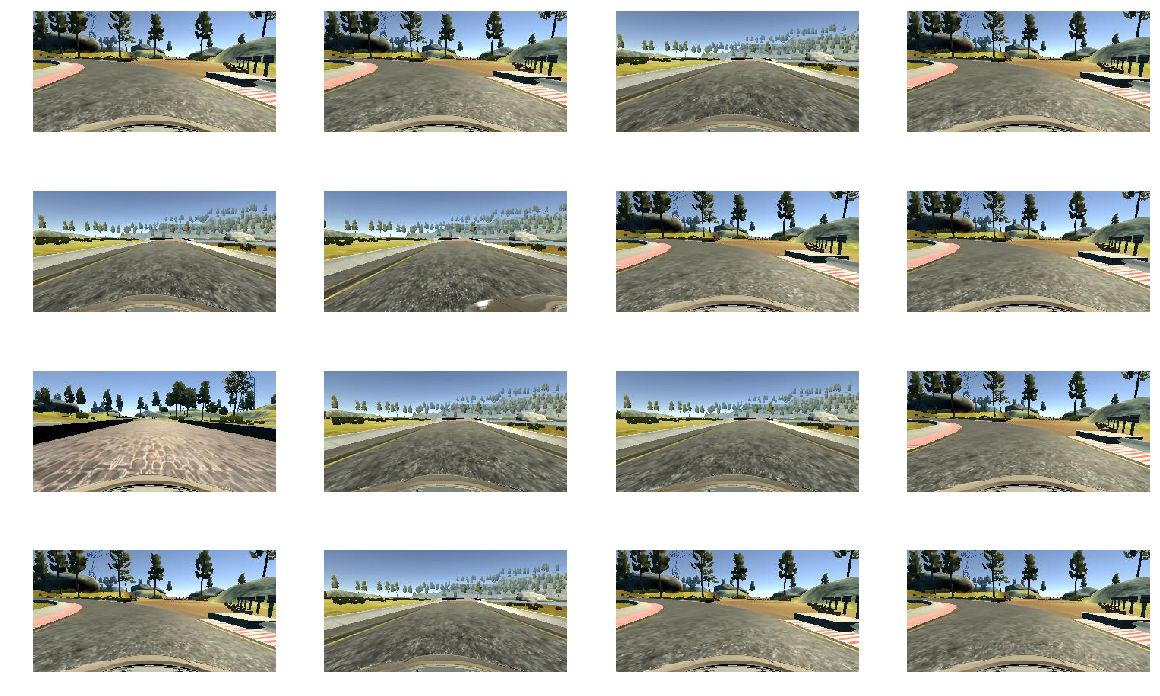

In [38]:
## Display sample of the ORIGINAL training images

fig = plt.figure(figsize=(20,16))

orig_images = X_images
sample = random.sample(range(len(X_aug)), 16)

for i in range(16):
    img = orig_images[sample[i]]
    ax = fig.add_subplot(5,4,i+1)
    ax.imshow(img.squeeze(), cmap="gray", interpolation='nearest')
    plt.axis('off')
plt.show()

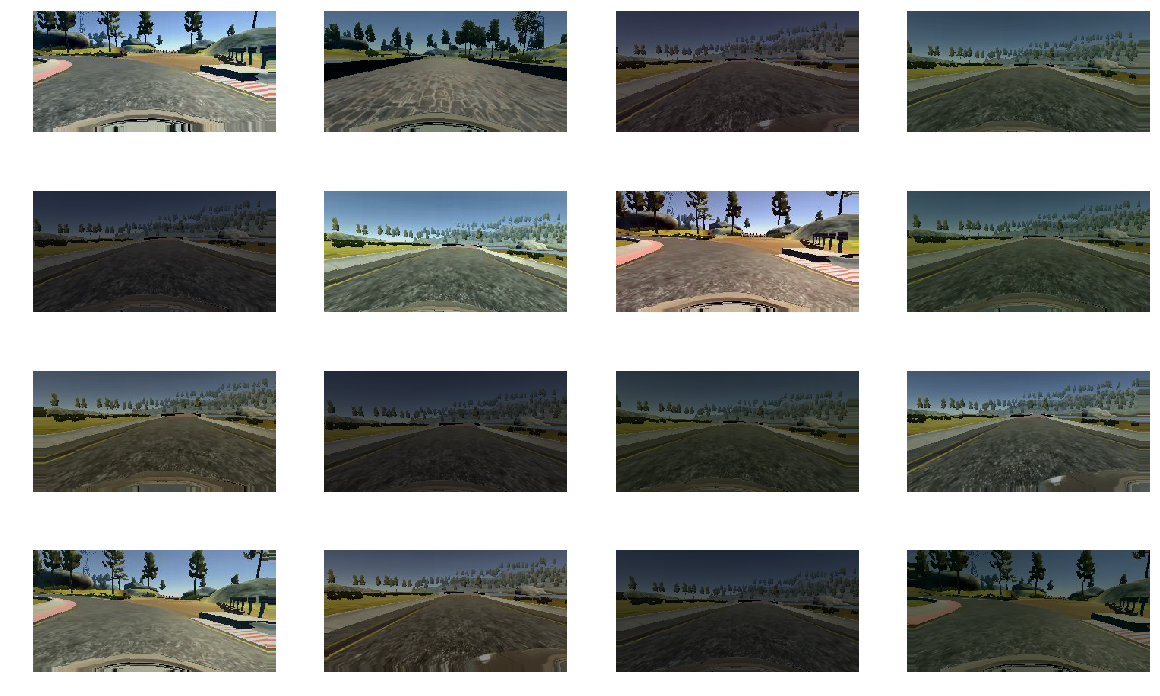

In [55]:
## Display sample of the TRANSFORMED training images, 1 image for each class

fig = plt.figure(figsize=(20,16)) 

sample = random.sample(range(len(X_aug)), 16)

for i in range(16):
    img = X_aug[i]
    ax = fig.add_subplot(5,4,i+1)
    ax.imshow(img.squeeze(), cmap="gray", interpolation='nearest')
    plt.axis('off')
plt.show()

In [ ]:
# ## Display a broader sample of AUGMENTED images, 12 from each class

# import matplotlib
# import matplotlib.pyplot as plt
# %matplotlib inline
# matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

# images_labels = list(train_images_dict.keys())
# for image_key in images_labels:        
#     subplots = 12
#     fig, axes = plt.subplots(1,subplots)
#     images_total = len(train_images_dict[image_key])
#     print('[{}] {}'.format(image_key, labels_dict[image_key]))
#     offset = images_total // subplots
#     images = [train_images_dict[image_key][j*offset] for j in range(subplots)]
#     for i, (image, ax) in enumerate(zip(images, axes)):
#         ax.imshow(image.squeeze())
#     plt.tight_layout()
#     plt.subplots_adjust(top=0.85)
#     plt.show()

# train_images_dict.clear()

### 2.6 | Training and Validation sets


#### Udacity data

In [58]:
## Create training and validation sets

X_train_ud = [(i[0], i[2]) for i in udacity_3cam]   # produces list of tuples [(image filename, source)]
y_train_ud = [i[1] for i in udacity_3cam]           # produces list of angles

# Split training and testing data
X_train_ud, X_valid_ud, y_train_ud, y_valid_ud = \
                train_test_split(X_train_ud, y_train_ud, test_size=0.2, random_state=0)

# Split out source data
src_train_ud = [i[1] for i in X_train_ud]
X_train_ud = [i[0] for i in X_train_ud]

src_valid_ud = [i[1] for i in X_valid_ud]
X_valid_ud = [i[0] for i in X_valid_ud]


# Number of training examples
n_train_ud = len(X_train_ud)

# Number of validation examples
n_valid_ud = len(X_valid_ud)

# Number of corresponding sources
n_src_train_ud = len(src_train_ud)
n_src_valid_ud = len(src_valid_ud)

# Verify that all counts match
print("Number of training examples: ", n_train_ud)
print("Number of validation examples: ", n_valid_ud)
print("Source counts: {} = {}, and {} = {} ".format(n_src_train_ud, n_train_ud, n_src_valid_ud, n_valid_ud))
print("----------\nVerify Totals: {} = {} ".format((n_train_ud+n_valid_ud), len(udacity_3cam)))

Number of training examples:  8119
Number of validation examples:  2030
Source counts: 8119 = 8119, and 2030 = 2030 
----------
Verify Totals: 10149 = 10149 


#### Self-generated data

In [76]:
## Create training and validation sets

X_train_self = [(i[0], i[2]) for i in self_3cam]   # produces list of tuples [(image filename, source)]
y_train_self = [i[1] for i in self_3cam]           # produces list of angles

# Split training and testing data
X_train_self, X_valid_self, y_train_self, y_valid_self = \
                train_test_split(X_train_self, y_train_self, test_size=0.2, random_state=0)

# Split out source data
src_train_self = [i[1] for i in X_train_self]
X_train_self = [i[0] for i in X_train_self]

src_valid_self = [i[1] for i in X_valid_self]
X_valid_self = [i[0] for i in X_valid_self]


# Number of training examples
n_train_self = len(X_train_self)

# Number of validation examples
n_valid_self = len(X_valid_self)

# Number of corresponding sources
n_src_train_self = len(src_train_self)
n_src_valid_self = len(src_valid_self)

# Verify that all counts match
print("Number of training examples: ", n_train_self)
print("Number of validation examples: ", n_valid_self)
print("Source counts: {} = {}, and {} = {} ".format(n_src_train_self, n_train_self, n_src_valid_self, n_valid_self))
print("----------\nVerify Totals: {} = {} ".format((n_train_self+n_valid_self), len(self_3cam)))

Number of training examples:  15735
Number of validation examples:  3934
Source counts: 15735 = 15735, and 3934 = 3934 
----------
Verify Totals: 19669 = 19669 


#### Combined

In [77]:
## Combine the training, validation, and source data sets

X_train = X_train_ud + X_train_self 
y_train = y_train_ud + y_train_self

X_valid = X_valid_ud + X_valid_self 
y_valid = y_valid_ud + y_valid_self

src_train = src_train_ud + src_train_self
src_valid = src_valid_ud + src_valid_self
    
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_valid = len(X_valid)

# Number of corresponding sources
n_src_train = len(src_train)
n_src_valid = len(src_valid)

# Verify that all counts match
print("Number of training examples: ", n_train)
print("Number of validation examples: ", n_valid)
print("Source counts: {} = {}, and {} = {} ".format(n_src_train, n_train, n_src_valid, n_valid))
print("----------\nVerify Totals: {} = {} ".format((n_train+n_valid), len(udacity_3cam)+len(self_3cam)))

Number of training examples:  23854
Number of validation examples:  5964
Source counts: 23854 = 23854, and 5964 = 5964 
----------
Verify Totals: 29818 = 29818 


---
## Step 3: Model Architecture
---

### Model

In [80]:
## Global variables and parameters

lr = 1e-4          # learning rate
reg = l2(1e-3)     # L2 reg
drop = 0.5

strides = (2, 2)
act = 'relu'
default_pad = 'same'


In [81]:
## Create and reset the model

model = Sequential()

model.add(Lambda(lambda x: x/255 - 0.5, input_shape=orig_shape))
model.add(Cropping2D(cropping=((60, 20), (20, 20))))

model.add(Convolution2D(24, 5, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
model.add(Convolution2D(48, 5, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
model.add(Convolution2D(96, 5, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Convolution2D(128, 3, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
model.add(Convolution2D(128, 3, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())
model.add(Dense(100, kernel_regularizer=reg))
model.add(Dropout(drop))
model.add(Dense(50, kernel_regularizer=reg))
model.add(Dropout(drop))
model.add(Dense(25, kernel_regularizer=reg))
model.add(Dropout(drop))
# model.add(Dense(10, kernel_regularizer=reg))
model.add(Dense(1))

# Compile and preview the model
model.compile(optimizer=Adam(lr=lr), loss='mean_squared_error', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_3 (Cropping2D)    (None, 80, 280, 3)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 40, 140, 24)       1824      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 20, 70, 48)        28848     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 10, 35, 96)        115296    
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 5, 18, 128)        110720    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 3, 9, 128)         147584    
__________

In [84]:
## Train and save the model

MODEL_DIR = "models/"

epochs = 3
batch_size = 64

n_img_gen = 4   # image output:input ratio from generator

train_steps = (n_img_gen * len(X_train)) // batch_size
val_steps = len(X_valid) // batch_size

train_gen = generator(X_train, y_train, src_train, val=False)
val_gen = generator(X_valid, y_valid, src_valid, val=True)

checkpoint = ModelCheckpoint('model{epoch:02d}.h5')
    
model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=epochs, \
                    validation_data=val_gen, validation_steps=val_steps, verbose=2, callbacks=[checkpoint])

print('\nDone Training')

# Save model and weights
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save("model.h5")
print("Model saved to disk")

Epoch 1/3
1490/1490 [==============================] - 633s - loss: 0.4289 - acc: 0.3846 - val_loss: 0.2570 - val_acc: 0.3997
Epoch 2/3
1490/1490 [==============================] - 627s - loss: 0.2215 - acc: 0.3934 - val_loss: 0.1586 - val_acc: 0.4051
Epoch 3/3
1490/1490 [==============================] - 625s - loss: 0.1586 - acc: 0.3975 - val_loss: 0.1186 - val_acc: 0.4106

Done Training
Saved model to disk


In [ ]:
## Train and save the model **ROUND 2**

epochs = 3

checkpoint = ModelCheckpoint('model{epoch:02d}.h5')
    
model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=epochs, \
                    validation_data=val_gen, validation_steps=val_steps, verbose=2, callbacks=[checkpoint])

print('\nDone Training')

# Save model and weights
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save("model.h5")
print("Model saved to disk")

Epoch 1/3
